# AI-Driven Environmental Optimization for Hydrogen Production
## Proof-of-Concept Simulation for *Chlamydomonas reinhardtii*
## 1. IMPORT LIBRARIES

In [21]:
import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import warnings
import logging

# Suppress Optuna info logs & other warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set visualization style
sns.set(style="whitegrid")
np.random.seed(42)


## 2. DEFINE BIOLOGICAL MODEL
We simulate hydrogen production (H2_yield) in C. reinhardtii under different environmental conditions.
Key controllable parameters:
    1. Light_intensity (µmol photons m^-2 s^-1)
    2. Light_spectrum (red:blue:green ratio)
    3. Sulfur_concentration (mM)
    4. Oxygen_level (% saturation)
    5. Temperature (°C)
    6. pH

Biological assumptions:
- High hydrogen production requires **low oxygen** (anaerobic conditions).
- Sulfur deprivation activates hydrogenase but extreme depletion damages growth.
- Blue:red light balance optimizes PSI electron flow.
- Optimal hydrogenase activity peaks at ~30°C and pH ~7.2.

In [23]:
# # Synthetic function for hydrogen yield based on biological constraints
# def hydrogen_yield(light_intensity, blue_ratio, sulfur, oxygen, temp, pH):
#     # Normalize inputs
def hydrogen_yield(light_intensity, blue_ratio, sulfur, oxygen, temp, pH):
    li = light_intensity / 300.0
    br = blue_ratio
    s = sulfur / 2.0
    o2 = 1 - (oxygen / 100.0)
    t = np.exp(-((temp - 30)**2) / (2 * 5**2))
    ph_effect = np.exp(-((pH - 7.2)**2) / (2 * 0.3**2))

    # Simulated hydrogen output (mmol H2 / L / hr)
    h2 = 15 * li * (br + 0.5) * (s + 0.3) * o2 * t * ph_effect
    
    # Add experimental noise
    noise = np.random.normal(0, 0.5)
    return max(h2 + noise, 0)


## 3. BAYESIAN OPTIMIZATION

In [28]:
# Objective function for Optuna
def objective(trial):
    light_intensity = trial.suggest_uniform("light_intensity", 50, 300)
    blue_ratio = trial.suggest_uniform("blue_ratio", 0.0, 1.0)
    sulfur = trial.suggest_uniform("sulfur", 0.1, 2.0)
    oxygen = trial.suggest_uniform("oxygen", 0, 20)
    temp = trial.suggest_uniform("temp", 20, 40)
    pH = trial.suggest_uniform("pH", 6.5, 8.0)
    return hydrogen_yield(light_intensity, blue_ratio, sulfur, oxygen, temp, pH)

# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=False)

print("Best parameters:")
print(study.best_params)
print("Max hydrogen yield:", round(study.best_value, 3), "mmol H2/L/hr")


Best parameters:
{'light_intensity': 258.45804816564197, 'blue_ratio': 0.9118248050421777, 'sulfur': 1.9016603841398132, 'oxygen': 0.6985828326154939, 'temp': 29.00236282583102, 'pH': 7.27870185995537}
Max hydrogen yield: 22.824 mmol H2/L/hr


## 4. VISUALIZATION

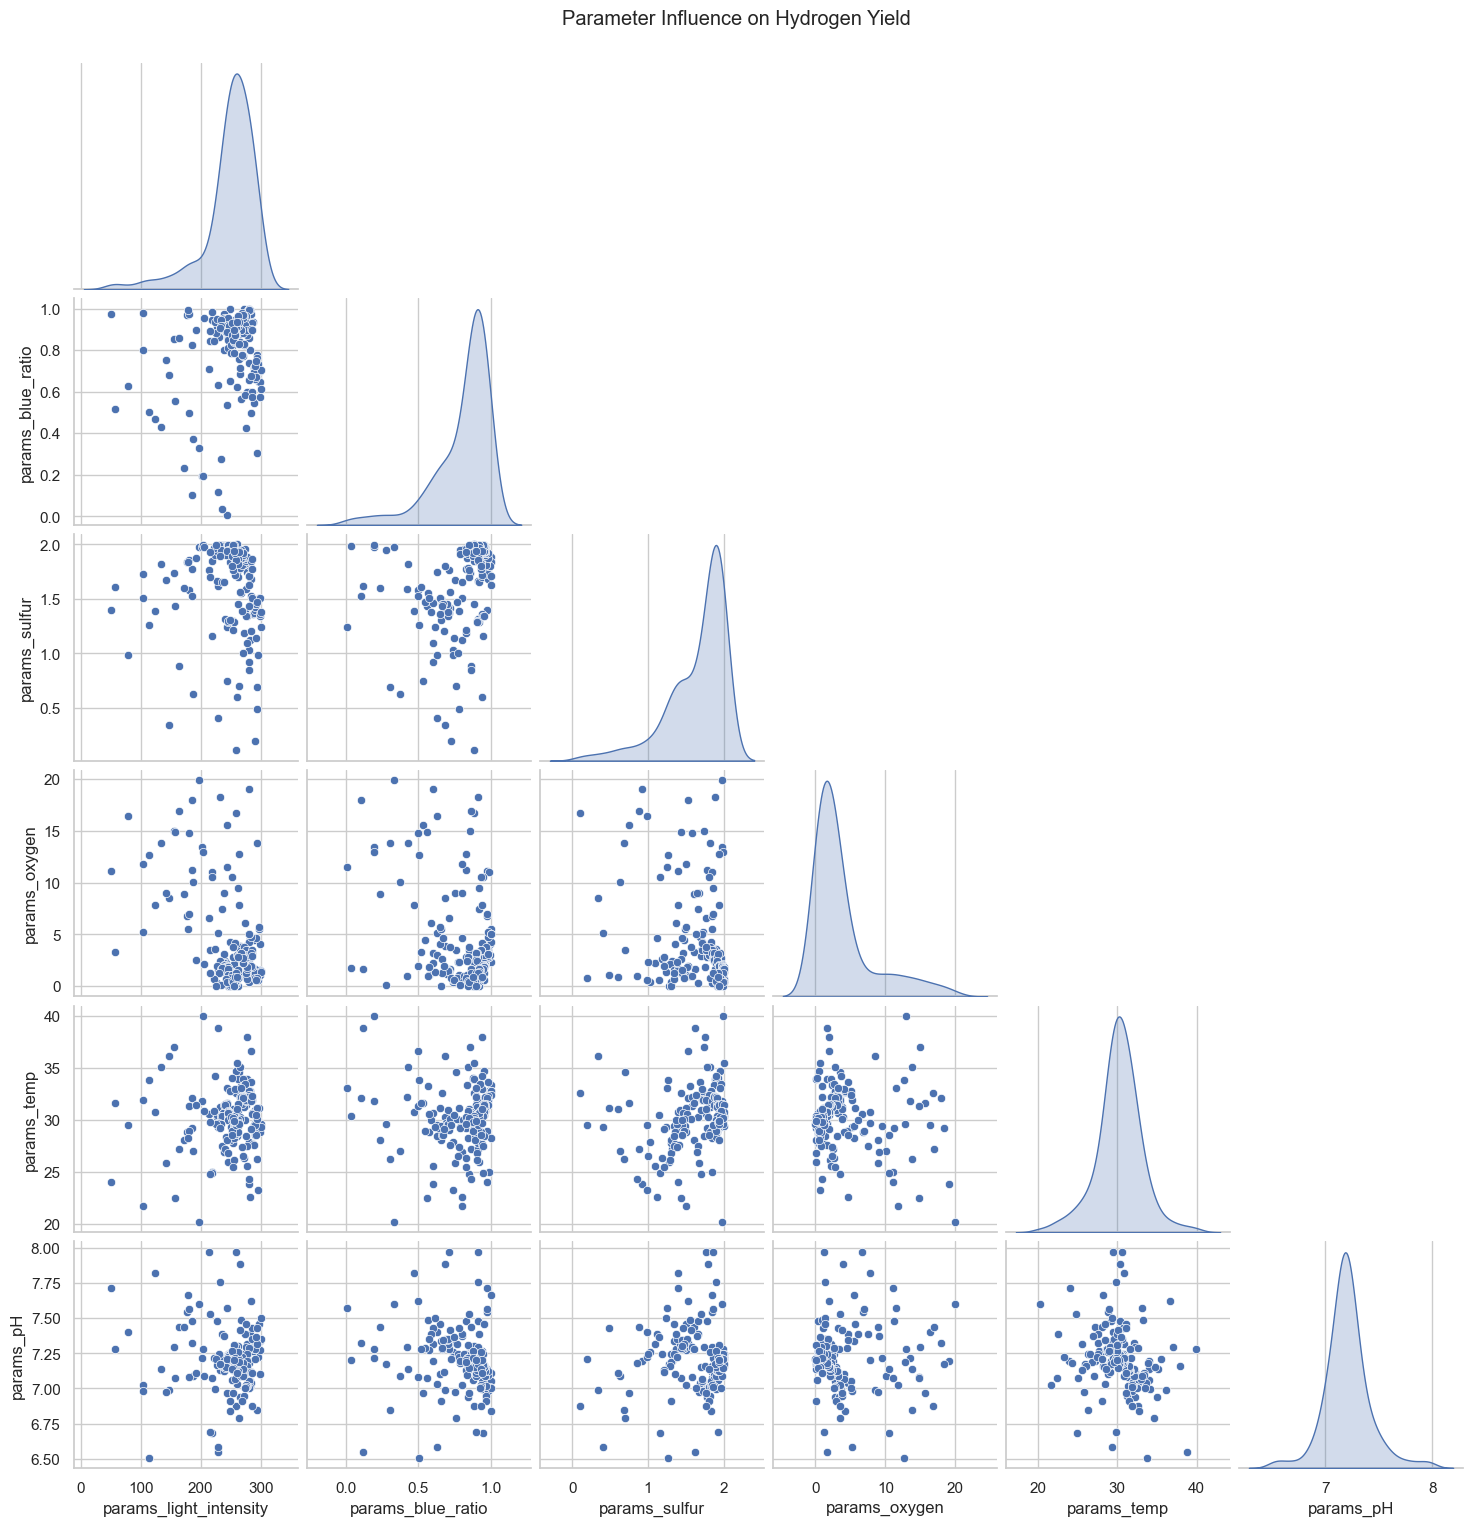

/var/folders/qh/fmzc9db1783cz_z1bj3znn44y1tlxj/T/ipykernel_7220/2710530939.py:10: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


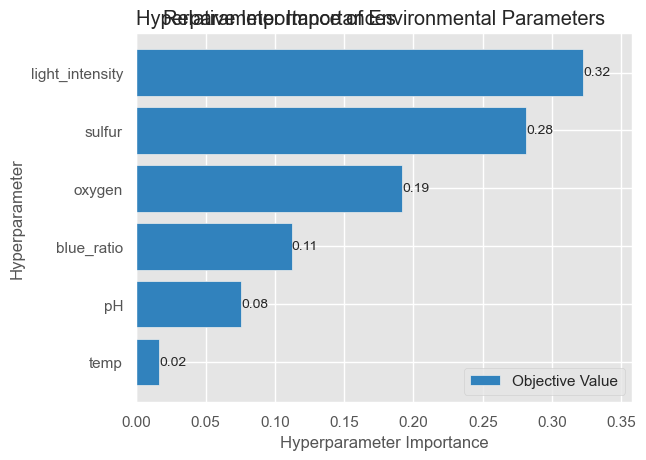

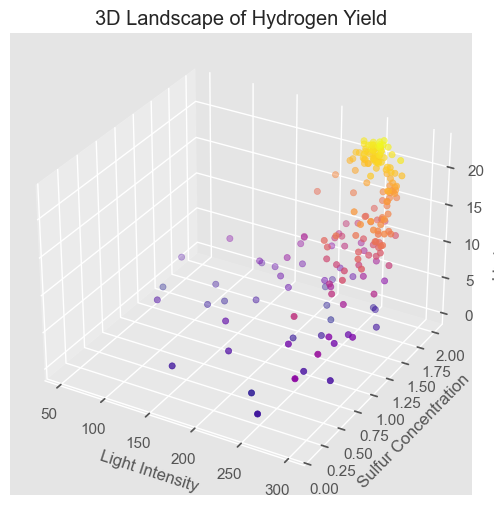

In [31]:
trials_df = study.trials_dataframe()
sns.pairplot(trials_df,
    vars=["params_light_intensity", "params_blue_ratio", "params_sulfur", "params_oxygen", "params_temp", "params_pH"],
    diag_kind="kde",
    corner=True)
plt.suptitle("Parameter Influence on Hydrogen Yield", y=1.02)
plt.show()

from optuna.visualization.matplotlib import plot_param_importances
plot_param_importances(study)
plt.title("Relative Importance of Environmental Parameters")
plt.show()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(trials_df["params_light_intensity"], trials_df["params_sulfur"], trials_df["value"],
           c=trials_df["value"], cmap="plasma")
ax.set_xlabel("Light Intensity")
ax.set_ylabel("Sulfur Concentration")
ax.set_zlabel("Hydrogen Yield")
plt.title("3D Landscape of Hydrogen Yield")
plt.show()


*This simulated pipeline demonstrates how an AI-driven photobioreactor system
could optimize environmental conditions for hydrogen production.
Results feed back into the DBTL cycle to refine synthetic chloroplast genome designs.*

## 5. INTERACTIVE REAL-TIME DASHBOARD

In [43]:
# FIX: Proper import for interactive dashboard
from ipywidgets import interact, FloatSlider

# Suppress Optuna info logs
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")

In [45]:
print("Launching interactive hydrogen optimization dashboard...")

def interactive_simulation(light_intensity, blue_ratio, sulfur, oxygen, temp, pH):
    h2 = hydrogen_yield(light_intensity, blue_ratio, sulfur, oxygen, temp, pH)
    plt.figure(figsize=(6,4))
    plt.bar(["Predicted H₂ Yield"], [h2], color="teal")
    plt.ylabel("mmol H₂ / L / hr")
    plt.title("Real-Time Hydrogen Production Simulation")
    plt.ylim(0, 15)
    plt.show()
    print(f"Predicted Hydrogen Yield: {h2:.3f} mmol H₂ / L / hr")

interact(
    interactive_simulation,
    light_intensity=FloatSlider(value=150, min=50, max=300, step=10, description='Light'),
    blue_ratio=FloatSlider(value=0.5, min=0.0, max=1.0, step=0.05, description='Blue Ratio'),
    sulfur=FloatSlider(value=1.0, min=0.1, max=2.0, step=0.1, description='Sulfur (mM)'),
    oxygen=FloatSlider(value=5.0, min=0.0, max=20.0, step=0.5, description='Oxygen (%)'),
    temp=FloatSlider(value=30.0, min=20.0, max=40.0, step=1.0, description='Temp (°C)'),
    pH=FloatSlider(value=7.2, min=6.5, max=8.0, step=0.05, description='pH')
);


Launching interactive hydrogen optimization dashboard...


interactive(children=(FloatSlider(value=150.0, description='Light', max=300.0, min=50.0, step=10.0), FloatSlid…

*This dashboard can simulate real-time control of environmental parameters and instantly visualize their effect on hydrogen output.*

## 6. AI powered Auto Optimize button INTERACTIVE REAL-TIME DASHBOARD

In [55]:
print("Launching interactive hydrogen optimization dashboard...")

# Extra imports for interactive UI
from ipywidgets import FloatSlider, Button, HBox, VBox, Output
from IPython.display import display, clear_output

# Create sliders
light_slider = FloatSlider(value=150, min=50, max=300, step=10, description='Light')
blue_slider = FloatSlider(value=0.5, min=0.0, max=1.0, step=0.05, description='Blue Ratio')
sulfur_slider = FloatSlider(value=1.0, min=0.1, max=2.0, step=0.1, description='Sulfur (mM)')
oxygen_slider = FloatSlider(value=5.0, min=0.0, max=20.0, step=0.5, description='Oxygen (%)')
temp_slider = FloatSlider(value=30.0, min=20.0, max=40.0, step=1.0, description='Temp (°C)')
ph_slider = FloatSlider(value=7.2, min=6.5, max=8.0, step=0.05, description='pH')

# Output area
out = Output()

# Plot updater
def update_plot(*args):
    with out:
        clear_output(wait=True)
        h2 = hydrogen_yield(light_slider.value, blue_slider.value, sulfur_slider.value,
                             oxygen_slider.value, temp_slider.value, ph_slider.value)
        plt.figure(figsize=(6,4))
        plt.bar(["Predicted H₂ Yield"], [h2])
        plt.ylabel("mmol H₂ / L / hr")
        plt.title("Real-Time Hydrogen Production Simulation")
        plt.ylim(0, 15)
        plt.show()
        print(f"Predicted Hydrogen Yield: {h2:.3f} mmol H₂ / L / hr")

# Attach listeners
for w in [light_slider, blue_slider, sulfur_slider, oxygen_slider, temp_slider, ph_slider]:
    w.observe(update_plot, names='value')

# Initial draw
update_plot()

# Auto-Optimize button using Optuna around current settings
opt_button = Button(description='Auto-Optimize (AI)', button_style='success')

def auto_optimize(_):
    # Local search bounds around current slider values for speed
    bounds = {
        'light_intensity': (max(50, light_slider.value-60), min(300, light_slider.value+60)),
        'blue_ratio': (max(0.0, blue_slider.value-0.3), min(1.0, blue_slider.value+0.3)),
        'sulfur': (max(0.1, sulfur_slider.value-0.6), min(2.0, sulfur_slider.value+0.6)),
        'oxygen': (max(0.0, oxygen_slider.value-5.0), min(20.0, oxygen_slider.value+5.0)),
        'temp': (max(20.0, temp_slider.value-5.0), min(40.0, temp_slider.value+5.0)),
        'pH': (max(6.5, ph_slider.value-0.3), min(8.0, ph_slider.value+0.3)),
    }

    def local_objective(trial):
        li = trial.suggest_float('light_intensity', *bounds['light_intensity'])
        br = trial.suggest_float('blue_ratio', *bounds['blue_ratio'])
        s = trial.suggest_float('sulfur', *bounds['sulfur'])
        o2 = trial.suggest_float('oxygen', *bounds['oxygen'])
        t = trial.suggest_float('temp', *bounds['temp'])
        phv = trial.suggest_float('pH', *bounds['pH'])
        return hydrogen_yield(li, br, s, o2, t, phv)

    local_study = optuna.create_study(direction='maximize')
    local_study.optimize(local_objective, n_trials=80, show_progress_bar=False)
    best = local_study.best_params

    # Snap sliders to the suggested optimum
    light_slider.value = best['light_intensity']
    blue_slider.value = best['blue_ratio']
    sulfur_slider.value = best['sulfur']
    oxygen_slider.value = best['oxygen']
    temp_slider.value = best['temp']
    ph_slider.value = best['pH']

    # Update plot to reflect new settings
    update_plot()

opt_button.on_click(auto_optimize)

# Layout and display
controls = VBox([
    HBox([light_slider, blue_slider]),
    HBox([sulfur_slider, oxygen_slider]),
    HBox([temp_slider, ph_slider]),
    opt_button
])

ui = HBox([controls, out])
display(ui)

Launching interactive hydrogen optimization dashboard...


*This dashboard includes an AI-powered Auto-Optimize button. It runs a fast local Bayesian search around the current settings, then snaps the sliders to the suggested optimum.*

## 7. INTERACTIVE REAL-TIME DASHBOARD WITH LOCAL + GLOBAL AI OPTIMIZATION

In [61]:
print("Launching interactive hydrogen optimization dashboard with AI auto-optimization...")

# Extra imports for interactivity
from ipywidgets import FloatSlider, Button, HBox, VBox, Output
from IPython.display import display, clear_output

# Create sliders
light_slider = FloatSlider(value=150, min=50, max=300, step=10, description='Light')
blue_slider = FloatSlider(value=0.5, min=0.0, max=1.0, step=0.05, description='Blue Ratio')
sulfur_slider = FloatSlider(value=1.0, min=0.1, max=2.0, step=0.1, description='Sulfur (mM)')
oxygen_slider = FloatSlider(value=5.0, min=0.0, max=20.0, step=0.5, description='Oxygen (%)')
temp_slider = FloatSlider(value=30.0, min=20.0, max=40.0, step=1.0, description='Temp (°C)')
ph_slider = FloatSlider(value=7.2, min=6.5, max=8.0, step=0.05, description='pH')

# Output area
out = Output()

# Plot updater
def update_plot(*args):
    with out:
        clear_output(wait=True)
        h2 = hydrogen_yield(light_slider.value, blue_slider.value, sulfur_slider.value,
                             oxygen_slider.value, temp_slider.value, ph_slider.value)
        plt.figure(figsize=(6,4))
        plt.bar(["Predicted H₂ Yield"], [h2], color="teal")
        plt.ylabel("mmol H₂ / L / hr")
        plt.title("Real-Time Hydrogen Production Simulation")
        plt.ylim(0, 15)
        plt.show()
        print(f"Predicted Hydrogen Yield: {h2:.3f} mmol H₂ / L / hr")

# Attach listeners
for w in [light_slider, blue_slider, sulfur_slider, oxygen_slider, temp_slider, ph_slider]:
    w.observe(update_plot, names='value')

# Initial draw
update_plot()

# LOCAL AI OPTIMIZATION

local_opt_button = Button(description='Local AI Optimize', button_style='success')

def local_optimize(_):
    bounds = {
        'light_intensity': (max(50, light_slider.value-60), min(300, light_slider.value+60)),
        'blue_ratio': (max(0.0, blue_slider.value-0.3), min(1.0, blue_slider.value+0.3)),
        'sulfur': (max(0.1, sulfur_slider.value-0.6), min(2.0, sulfur_slider.value+0.6)),
        'oxygen': (max(0.0, oxygen_slider.value-5.0), min(20.0, oxygen_slider.value+5.0)),
        'temp': (max(20.0, temp_slider.value-5.0), min(40.0, temp_slider.value+5.0)),
        'pH': (max(6.5, ph_slider.value-0.3), min(8.0, ph_slider.value+0.3)),
    }

    def local_objective(trial):
        li = trial.suggest_float('light_intensity', *bounds['light_intensity'])
        br = trial.suggest_float('blue_ratio', *bounds['blue_ratio'])
        s = trial.suggest_float('sulfur', *bounds['sulfur'])
        o2 = trial.suggest_float('oxygen', *bounds['oxygen'])
        t = trial.suggest_float('temp', *bounds['temp'])
        phv = trial.suggest_float('pH', *bounds['pH'])
        return hydrogen_yield(li, br, s, o2, t, phv)

    local_study = optuna.create_study(direction='maximize')
    local_study.optimize(local_objective, n_trials=80, show_progress_bar=False)
    best = local_study.best_params

    # Snap sliders to local optimum
    light_slider.value = best['light_intensity']
    blue_slider.value = best['blue_ratio']
    sulfur_slider.value = best['sulfur']
    oxygen_slider.value = best['oxygen']
    temp_slider.value = best['temp']
    ph_slider.value = best['pH']
    update_plot()

local_opt_button.on_click(local_optimize)

# GLOBAL AI OPTIMIZATION

global_opt_button = Button(description='Global AI Optimize', button_style='info')

def global_optimize(_):
    def global_objective(trial):
        li = trial.suggest_float('light_intensity', 50, 300)
        br = trial.suggest_float('blue_ratio', 0.0, 1.0)
        s = trial.suggest_float('sulfur', 0.1, 2.0)
        o2 = trial.suggest_float('oxygen', 0, 20)
        t = trial.suggest_float('temp', 20, 40)
        phv = trial.suggest_float('pH', 6.5, 8.0)
        return hydrogen_yield(li, br, s, o2, t, phv)

    global_study = optuna.create_study(direction='maximize')
    global_study.optimize(global_objective, n_trials=200, show_progress_bar=False)
    best = global_study.best_params

    # Snap sliders to global optimum
    light_slider.value = best['light_intensity']
    blue_slider.value = best['blue_ratio']
    sulfur_slider.value = best['sulfur']
    oxygen_slider.value = best['oxygen']
    temp_slider.value = best['temp']
    ph_slider.value = best['pH']
    update_plot()

global_opt_button.on_click(global_optimize)

# LAYOUT AND DISPLAY

controls = VBox([
    HBox([light_slider, blue_slider]),
    HBox([sulfur_slider, oxygen_slider]),
    HBox([temp_slider, ph_slider]),
    HBox([local_opt_button, global_opt_button])
])

ui = HBox([controls, out])
display(ui)

Launching interactive hydrogen optimization dashboard with AI auto-optimization...


This dashboard supports **two AI optimization modes**:
- **Local AI Optimize** → Finds the best settings near your current sliders.
- **Global AI Optimize** → Searches the entire parameter space for the absolute best hydrogen production conditions.

## 8. MULTI-OBJECTIVE AI OPTIMIZATION (HYDROGEN YIELD + GROWTH)

In [66]:
multi_opt_button = Button(description='Multi-Objective Optimize', button_style='warning')

def estimate_growth(light_intensity, sulfur, temp):
    """Simple growth proxy based on balanced light, sulfur, and temperature."""
    # Growth peaks near 180 µmol light, declines if too high or low
    light_score = np.exp(-((light_intensity - 180)**2) / (2 * 60**2))
    # Sulfur promotes growth up to ~1.2 mM but drops after depletion
    sulfur_score = np.exp(-((sulfur - 1.2)**2) / (2 * 0.4**2))
    # Temperature optimal around 28-32°C
    temp_score = np.exp(-((temp - 30)**2) / (2 * 4**2))
    return light_score * sulfur_score * temp_score

def multi_objective_optimize(_):
    def multi_objective(trial):
        li = trial.suggest_float('light_intensity', 50, 300)
        br = trial.suggest_float('blue_ratio', 0.0, 1.0)
        s = trial.suggest_float('sulfur', 0.1, 2.0)
        o2 = trial.suggest_float('oxygen', 0, 20)
        t = trial.suggest_float('temp', 20, 40)
        phv = trial.suggest_float('pH', 6.5, 8.0)

        h2 = hydrogen_yield(li, br, s, o2, t, phv)
        growth = estimate_growth(li, s, t)
        return h2, growth

    multi_study = optuna.create_study(directions=['maximize', 'maximize'])
    multi_study.optimize(multi_objective, n_trials=150, show_progress_bar=False)

    # Select a Pareto-optimal point that balances H₂ yield and growth
    pareto_point = sorted(multi_study.best_trials, key=lambda t: t.values[0] + t.values[1], reverse=True)[0]
    best = pareto_point.params

    # Update sliders
    light_slider.value = best['light_intensity']
    blue_slider.value = best['blue_ratio']
    sulfur_slider.value = best['sulfur']
    oxygen_slider.value = best['oxygen']
    temp_slider.value = best['temp']
    ph_slider.value = best['pH']

    # Update visualization
    update_plot()

multi_opt_button.on_click(multi_objective_optimize)

# UPDATED LAYOUT WITH MULTI-OBJECTIVE MODE

controls = VBox([
    HBox([light_slider, blue_slider]),
    HBox([sulfur_slider, oxygen_slider]),
    HBox([temp_slider, ph_slider]),
    HBox([local_opt_button, global_opt_button, multi_opt_button])
])

ui = HBox([controls, out])
display(ui)

This dashboard has **three AI optimization modes**:
1. **Local AI Optimize** → Finds the best settings near your current values.
2. **Global AI Optimize** → Searches the entire environmental range for the highest hydrogen yield.
3. **Multi-Objective Optimize** → Balances **hydrogen production** and **algal growth** using Pareto-optimal solutions.
This makes the simulation closer to an **industrial-scale AI-driven bioenergy platform**.

## 7. REAL-TIME 3D PARETO FRONT VISUALIZATION

In [71]:
from mpl_toolkits.mplot3d import Axes3D

def plot_pareto_front(multi_study):
    """3D Pareto front showing hydrogen yield vs growth vs light intensity."""
    pareto_trials = [t for t in multi_study.best_trials]
    h2_vals = [t.values[0] for t in pareto_trials]
    growth_vals = [t.values[1] for t in pareto_trials]
    light_vals = [t.params['light_intensity'] for t in pareto_trials]

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(h2_vals, growth_vals, light_vals,
                         c=h2_vals, cmap='viridis', s=60, alpha=0.8)

    ax.set_xlabel("Hydrogen Yield (mmol H₂/L/hr)")
    ax.set_ylabel("Growth Potential (normalized)")
    ax.set_zlabel("Light Intensity (µmol m⁻² s⁻¹)")
    ax.set_title("AI-Discovered Pareto Front for Hydrogen vs Growth")
    fig.colorbar(scatter, ax=ax, shrink=0.6, label='Hydrogen Yield')
    plt.show()

# Update multi-objective function to automatically plot Pareto front after optimization
def multi_objective_optimize(_):
    def multi_objective(trial):
        li = trial.suggest_float('light_intensity', 50, 300)
        br = trial.suggest_float('blue_ratio', 0.0, 1.0)
        s = trial.suggest_float('sulfur', 0.1, 2.0)
        o2 = trial.suggest_float('oxygen', 0, 20)
        t = trial.suggest_float('temp', 20, 40)
        phv = trial.suggest_float('pH', 6.5, 8.0)
        h2 = hydrogen_yield(li, br, s, o2, t, phv)
        growth = estimate_growth(li, s, t)
        return h2, growth

    multi_study = optuna.create_study(directions=['maximize', 'maximize'])
    multi_study.optimize(multi_objective, n_trials=150, show_progress_bar=False)

    pareto_point = sorted(multi_study.best_trials, key=lambda t: t.values[0] + t.values[1], reverse=True)[0]
    best = pareto_point.params

    # Update sliders
    light_slider.value = best['light_intensity']
    blue_slider.value = best['blue_ratio']
    sulfur_slider.value = best['sulfur']
    oxygen_slider.value = best['oxygen']
    temp_slider.value = best['temp']
    ph_slider.value = best['pH']
    update_plot()

    # NEW: Show Pareto front visualization
    plot_pareto_front(multi_study)

multi_opt_button.on_click(multi_objective_optimize)

## 8. FULLY INTERACTIVE 3D PARETO EXPLORER (PLOTLY)

In [74]:
import plotly.graph_objects as go

def plot_interactive_pareto(multi_study):
    pareto_trials = [t for t in multi_study.best_trials]

    # Extract key metrics
    h2_vals = [t.values[0] for t in pareto_trials]
    growth_vals = [t.values[1] for t in pareto_trials]
    light_vals = [t.params['light_intensity'] for t in pareto_trials]
    sulfur_vals = [t.params['sulfur'] for t in pareto_trials]
    oxygen_vals = [t.params['oxygen'] for t in pareto_trials]

    # Create hover labels with detailed parameter info
    hover_texts = [
        f"<b>Hydrogen Yield:</b> {h2:.3f} mmol/L/hr" +
        f"<br><b>Growth Score:</b> {g:.3f}" +
        f"<br><b>Light Intensity:</b> {l:.1f} µmol" +
        f"<br><b>Sulfur:</b> {s:.2f} mM" +
        f"<br><b>Oxygen:</b> {o:.2f} %"
        for h2, g, l, s, o in zip(h2_vals, growth_vals, light_vals, sulfur_vals, oxygen_vals)
    ]

    # Build interactive 3D scatter plot
    fig = go.Figure(data=[
        go.Scatter3d(
            x=h2_vals,
            y=growth_vals,
            z=light_vals,
            mode='markers',
            marker=dict(
                size=6,
                color=h2_vals,
                colorscale='Viridis',
                opacity=0.85,
                colorbar=dict(title='Hydrogen Yield')
            ),
            text=hover_texts,
            hoverinfo='text'
        )
    ])

    fig.update_layout(
        scene=dict(
            xaxis_title='Hydrogen Yield (mmol H₂/L/hr)',
            yaxis_title='Growth Potential (normalized)',
            zaxis_title='Light Intensity (µmol m⁻² s⁻¹)'
        ),
        title="Interactive Pareto Front: Hydrogen Yield vs Growth vs Light",
        height=700
    )

    fig.show()

# Update multi-objective function to launch the explorer

def multi_objective_optimize(_):
    def multi_objective(trial):
        li = trial.suggest_float('light_intensity', 50, 300)
        br = trial.suggest_float('blue_ratio', 0.0, 1.0)
        s = trial.suggest_float('sulfur', 0.1, 2.0)
        o2 = trial.suggest_float('oxygen', 0, 20)
        t = trial.suggest_float('temp', 20, 40)
        phv = trial.suggest_float('pH', 6.5, 8.0)
        h2 = hydrogen_yield(li, br, s, o2, t, phv)
        growth = estimate_growth(li, s, t)
        return h2, growth

    multi_study = optuna.create_study(directions=['maximize', 'maximize'])
    multi_study.optimize(multi_objective, n_trials=150, show_progress_bar=False)

    pareto_point = sorted(multi_study.best_trials, key=lambda t: t.values[0] + t.values[1], reverse=True)[0]
    best = pareto_point.params

    # Update sliders
    light_slider.value = best['light_intensity']
    blue_slider.value = best['blue_ratio']
    sulfur_slider.value = best['sulfur']
    oxygen_slider.value = best['oxygen']
    temp_slider.value = best['temp']
    ph_slider.value = best['pH']

    # Refresh plot and launch interactive Pareto explorer
    update_plot()
    plot_interactive_pareto(multi_study)

multi_opt_button.on_click(multi_objective_optimize)

This dashboard includes an **interactive 3D Pareto explorer** using **Plotly**:
- We can **rotate** the 3D view.
- **Zoom** into regions of interest.
- **Hover** over any point to inspect exact environmental settings and hydrogen yields.

This is a **next-generation AI-driven bioenergy simulator**, showing the decision-making power of the AI system.